In [2]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

import numpy as np
from PIL import Image

In [2]:
# Load the image and preprocess it for DenseNet121
img_path = "test_image.jpg"  # replace this with your image path
img = Image.open(img_path)
img = img.resize((224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the pre-trained DenseNet121 for image identification
image_model = DenseNet121(weights='imagenet')
preds = image_model.predict(x)

# turns predictions into a list of tuples
print('Predicted:', decode_predictions(preds, top=3)[0])

# gets the top ones
top_preds = [x[1] for x in decode_predictions(preds, top=3)[0]]

# Gets object(s) as keyword(s) for the poem model
seed_words = [desc.replace('_', ' ') for desc in top_preds]
seed_word = seed_words[0] if seed_words else None



35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02132136', 'brown_bear', 0.99491477), ('n02134084', 'ice_bear', 0.0025408035), ('n02133161', 'American_black_bear', 0.0008688594)]


In [4]:
#poem generation model

# Load the Gutenberg dataset
df = pd.read_parquet('gutenburg.parquet')

# Remove lines that contain non-ASCII chars
df = df[df['line'].map(lambda x: x.isascii())]

# Join all lines into a single string of text
text = df['line'].str.cat(sep=' ')

# sorted list of unique chars and dicts mapping chars to indices and vice versa
chars = sorted(list(set(text)))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
seqlen = 30  # sequence length, reduce if training time becomes an issue

# create training data from gutenburg dataset
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, seqlen, len(chars)), dtype=bool)
        y = np.zeros((batch_size, len(chars)), dtype=bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t, char_indices[w]] = 1
            y[i, char_indices[next_word_list[index % len(sentence_list)]]] = 1
            index = index + 1
        yield x, y

# declaration & loop for next chars and sentences
sentences = []
next_chars = []
step = seqlen
for i in range(0, len(text) - seqlen - 1, step):
    sentences.append(text[i: i + seqlen])
    next_chars.append(text[i + seqlen])

In [5]:
# LSTM model for poem generation
model = Sequential()
model.add(LSTM(120, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(LSTM(120, return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 120)           105600    
                                                                 
 lstm_1 (LSTM)               (None, 30, 120)           115680    
                                                                 
 dense (Dense)               (None, 30, 99)            11979     
                                                                 
Total params: 233,259
Trainable params: 233,259
Non-trainable params: 0
_________________________________________________________________


In [6]:
# helper method for index sampling
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)

In [7]:
#generate progress text after each epoch
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - seqlen - 1)

    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

#set batch size
batch_size = 1028

In [13]:
# print out the size of the chars set
print(len(chars))

99


In [8]:
model.load_weights('./2_by_120')

In [10]:
for diversity in [.1,.4,.5,.6,1.0]:
    print('----- diversity:', diversity)

    generated = ''
    # padding applied to seed word to generate usable output
    sentence = " " * (seqlen - len(seed_word) - 1) + seed_word + " "
    sentence = sentence[0:seqlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(200):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

----- diversity: 0.1
----- Generating with seed: "                   brown bear "
                   brown bear and the stars of the stars of the stars of the stars of the stars of the seas of the stars of the stars of the stars of the stars of the started state, And the state of the stream of the stars of the 
----- diversity: 0.4
----- Generating with seed: "                   brown bear "
                   brown bear a street that they were the stream, And stand and seas the star of his preserval passion of the world of the Carries, The great soul of the hands of summer extingues the fate, And in the spirit of the
----- diversity: 0.5
----- Generating with seed: "                   brown bear "
                   brown bear as he thought a night of what my soul and state, While the three shades and the words of hours, That he shall find the purpose when I know the ride. So with the state of the last days of the great pai
----- diversity: 0.6
----- Generating with seed: "           

In [21]:
# combined method for image->poem generation

def make_poem(image_path="test_image.jpg", diversity=.5, poem_length=200, seqlen=30):
    # Load the image and preprocess it for DenseNet121
    img = Image.open(image_path)
    img = img.resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the pre-trained DenseNet121 for image identification
    image_model = DenseNet121(weights='imagenet')
    image_preds = image_model.predict(x)

    # turns predictions into a list of tuples
    print('Predicted:', decode_predictions(image_preds, top=3)[0])

    # gets the top ones
    top_preds = [x[1] for x in decode_predictions(image_preds, top=3)[0]]

    # Gets object(s) as keyword(s) for the poem model
    seed_words = [desc.replace('_', ' ') for desc in top_preds]
    seed_word = seed_words[0] if seed_words else None

    # output the text
    print('----- diversity:', diversity)

    generated = ''
    # padding applied to seed word to generate usable output
    sentence = " " * (seqlen - len(seed_word) - 1) + seed_word + " "
    sentence = sentence[0:seqlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(poem_length):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    

In [24]:
print("Image 1:")
make_poem(diversity=.4)
print("Image 2:")
make_poem(image_path="person.jpg", diversity=.5)
print("Image 3:")
make_poem(image_path="mountain.jpg", diversity=.6)

Image 1:
1/1 [==============================] - 2s 2s/step
Predicted: [('n02132136', 'brown_bear', 0.9949151), ('n02134084', 'ice_bear', 0.0025641413), ('n02133161', 'American_black_bear', 0.00082763087)]
----- diversity: 0.4
----- Generating with seed: "                   brown bear "
                   brown bear the last and the bells of his blood, and the same design I know the whole been Proper the parting streams, Who knows the started seas the form of heaven, And heart and brisks of the tall of the hills 
Image 2:
1/1 [==============================] - 2s 2s/step
Predicted: [('n02883205', 'bow_tie', 0.37093672), ('n04350905', 'suit', 0.22787917), ('n04591157', 'Windsor_tie', 0.22401868)]
----- diversity: 0.5
----- Generating with seed: "                      bow tie "
                      bow tie a care Shut him in the sign fair with the man. The sea-servant was the wind of his breast; The narrow calls with a standing sight, And men in the fury of the cast of a blood; And the w

In [ ]:
#train model
model.fit(generator(sentences, next_chars, batch_size),
          steps_per_epoch=int(len(sentences)/batch_size),
          epochs=50,
          callbacks=[print_callback])

In [11]:
#poem generation model
# Load the Gutenberg dataset
# Data is re-loaded here to accommodate a different preprocessing form used before settling on the one above
df = pd.read_parquet('gutenburg.parquet')

# Remove lines that contain non-ASCII chars
df = df[df['line'].map(lambda x: x.isascii())]

chars = sorted(list(set(df['line'].str.cat(sep=' '))))
print(chars)

['\x01', '\x07', '\t', '\x1a', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


In [12]:
ids = set()
# print each unique gutenberg id
for id in df['gutenberg_id']:
    ids.add(id)
print(sorted(ids))
print(len(ids))

# append each line of the randomly selected

train_ids = random.choices(list(ids), k= 50)
print(train_ids)

t = df.loc[df['gutenberg_id'].isin(train_ids)]
print(t)

[19, 20, 26, 58, 109, 136, 151, 163, 207, 213, 214, 228, 230, 232, 246, 257, 258, 259, 261, 262, 263, 264, 266, 301, 304, 309, 312, 313, 315, 317, 323, 328, 348, 353, 390, 391, 392, 397, 400, 409, 413, 424, 438, 441, 442, 454, 458, 487, 574, 579, 591, 592, 594, 595, 596, 602, 610, 615, 617, 618, 651, 658, 679, 680, 691, 692, 703, 715, 772, 785, 791, 795, 835, 841, 845, 937, 941, 962, 981, 982, 995, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1019, 1020, 1021, 1030, 1031, 1034, 1035, 1040, 1041, 1042, 1045, 1054, 1057, 1062, 1141, 1151, 1165, 1166, 1186, 1199, 1211, 1229, 1238, 1246, 1247, 1279, 1280, 1287, 1304, 1317, 1321, 1322, 1333, 1358, 1365, 1381, 1382, 1383, 1393, 1418, 1459, 1469, 1471, 1505, 1506, 1525, 1543, 1544, 1545, 1567, 1568, 1612, 1645, 1664, 1719, 1727, 1728, 1731, 1745, 1746, 1830, 1847, 1852, 1855, 1894, 1919, 1924, 1934, 1953, 1958, 1962, 1974, 1978, 1995, 1996, 1997, 2002, 2003, 2008, 2080, 2136, 2151, 2161, 2199, 2294, 2303, 2304, 2334, 2378, 2381, 2383, 2388

In [13]:
# Join all lines into a single string of text
text = t['line'].str.cat(sep=' ')
print(len(text))

5868864


In [14]:
# sorted list of unique chars and dicts mapping chars to indices and vice versa
chars = sorted(list(set(df['line'].str.cat(sep=' ')))) # should be changed to set(df['line']) in order to allow for evaluation
print(len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

99


In [15]:
seqlen = 60
step = seqlen
sentences = []
for i in range(0, len(text) - seqlen - 1, step):
    sentences.append(text[i: i + seqlen + 1])

x = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1

In [16]:
# Comparing evaluation metrics across several different architectures

# create models for cross-comparison
model1 = Sequential()
model1.add(LSTM(120, input_shape=(seqlen, len(chars)), return_sequences=True))
model1.add(Dense(len(chars), activation='softmax'))

# compile the models
model1.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy'])

# test performance across the 150 poem example dataset
# 10 epochs each model
h1 = model1.fit(x,y,
         batch_size= batch_size,
         epochs=10,
         verbose= 0)

In [18]:
model1 = Sequential()
model1.add(LSTM(120, input_shape=(seqlen, len(chars)), return_sequences=True))
model1.add(LSTM(120, return_sequences=True))
model1.add(Dense(len(chars), activation='softmax'))

model1.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy'])

h2 = model1.fit(x,y,
         batch_size= batch_size,
         epochs=10,
         verbose= 0)

In [19]:
model1 = Sequential()
model1.add(LSTM(64, input_shape=(seqlen, len(chars)), return_sequences=True))
model1.add(LSTM(64, return_sequences=True))
model1.add(Dense(len(chars), activation='softmax'))

model1.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy'])

h3 = model1.fit(x,y,
         batch_size= batch_size,
         epochs=10,
         verbose= 0)

In [20]:
model1 = Sequential()
model1.add(LSTM(256, input_shape=(seqlen, len(chars)), return_sequences=True))
model1.add(LSTM(256, return_sequences=True))
model1.add(Dense(len(chars), activation='softmax'))

model1.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy'])

h4 = model1.fit(x,y,
         batch_size= batch_size,
         epochs=10,
         verbose= 0)

In [21]:
# list all data in history
print(h1.history.keys())

dict_keys(['loss', 'categorical_crossentropy', 'accuracy'])


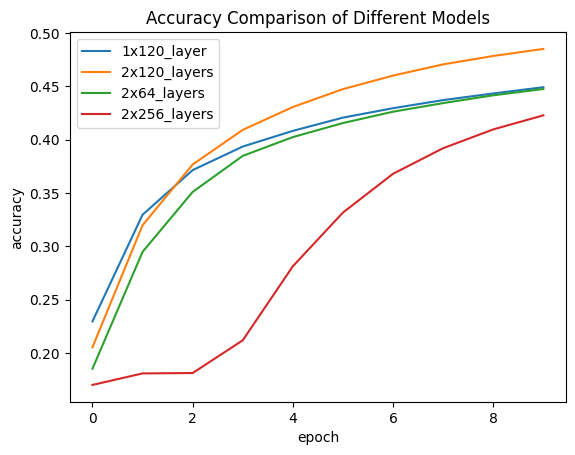

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(h1.history['accuracy'])
plt.plot(h2.history['accuracy'])
plt.plot(h3.history['accuracy'])
plt.plot(h4.history['accuracy'])
plt.title('Accuracy Comparison of Different Models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['1x120_layer', '2x120_layers', '2x64_layers', '2x256_layers'], loc='upper left')
plt.show()


plt.savefig("accuracy_comparison")

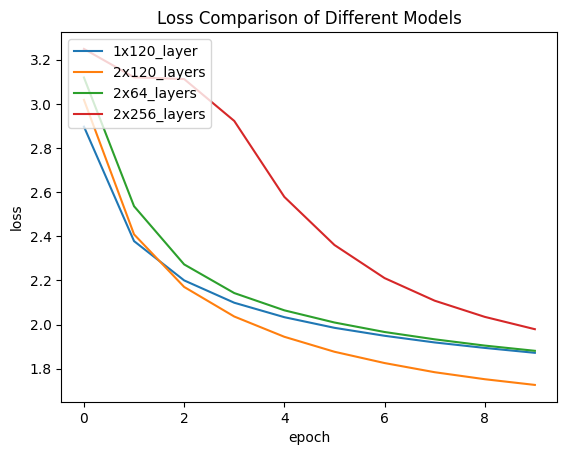

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(h1.history['loss'])
plt.plot(h2.history['loss'])
plt.plot(h3.history['loss'])
plt.plot(h4.history['loss'])
plt.title('Loss Comparison of Different Models')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1x120_layer', '2x120_layers', '2x64_layers', '2x256_layers'], loc='upper left')
plt.show()

plt.savefig("loss_comparison")

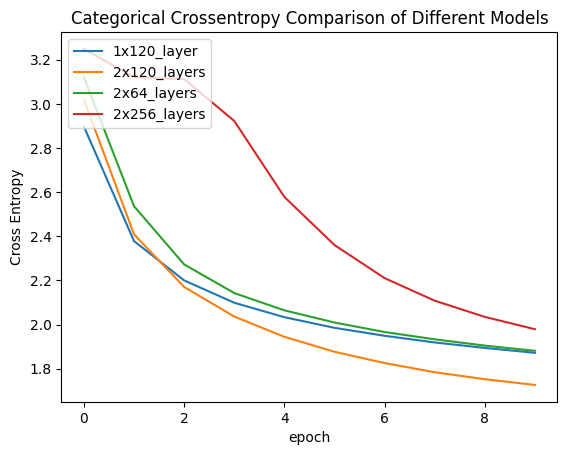

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(h1.history['categorical_crossentropy'])
plt.plot(h2.history['categorical_crossentropy'])
plt.plot(h3.history['categorical_crossentropy'])
plt.plot(h4.history['categorical_crossentropy'])
plt.title('Categorical Crossentropy Comparison of Different Models')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.legend(['1x120_layer', '2x120_layers', '2x64_layers', '2x256_layers'], loc='upper left')
plt.show()

plt.savefig("entropy_comparison")